In [36]:
from pathlib import Path
from typing import Dict, List, Union
from PIL import Image
from skimage import restoration

import imageio.v3 as iio
import pandas as pd
import trackpy as tp
import numpy.typing as npt
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

Work done untill now :
- Loading the data in a dict [Red, Green]
- Eliminate the background
- Detect the peaks
- Link features into particle trajectories

**Used fonctions :**
- load_data
- detect_peaks

In [2]:
def load_data(filepath: Union[Path, str], color_sequence: List[str]) -> Dict:
    """Return the deinterlaced films contained in the file.

    The original file is a .tiff or .tif film where frames are interlaced, e.g.
    `[red_frame, green_frame, red_frame, green_frame,...]`.
    The order of the colors is given in `color_sequence`. For instance, if
    `color_sequence=["red", "green"]` then the ouput is a dictionary:
    `{"red": red_frames_array, "green": green_frames_array}`.

    Args:
        filepath (Union[Path, str]): path to the film (e.g.
            "c:\\users\\john\\documents\\project\\film.tif")
        color_sequence (List[str]): colors of the frames, in the correct order.

    Returns:
        Dict: dictionary {"color": numpy array}
    """
    video = iio.imread(filepath).astype(float)
    n_colors = len(color_sequence)
    res_dict = {
        color: video[k_color::n_colors]
        for (k_color, color) in enumerate(color_sequence)
    }
    return res_dict

In [3]:
def detect_peaks(
    frames: npt.NDArray, diameter: int, minmass: float, percentile: float
) -> pd.DataFrame:
    """Detect the peaks.

    Args:
        frames (npt.NDArray): shape (n_frames, height, width)
        diameter (int): This may be a single number or a tuple giving the
            feature's extent in each dimension, useful when the dimensions do
            not have equal resolution (e.g. confocal microscopy). The tuple
            order is the same as the image shape, conventionally (z, y, x) or
            (y, x). The number(s) must be odd integers. When in doubt, round up.
        minmass (float): The minimum integrated brightness. This is a crucial
            parameter for eliminating spurious features. Recommended minimum
            values are 100 for integer images and 1 for float images.
        percentile (float): Features must have a peak brighter than pixels in
            this percentile. This helps eliminate spurious peaks.


    Returns:
        npt.NDArray: Dataframe with columns [x, y, mass, size, ecc, signal]
            where mass means total integrated brightness of the blob, size means
            the radius of gyration of its Gaussian-like profile, and ecc is its
            eccentricity (0 is circular).
    """
    out = tp.batch(
        frames=frames,
        diameter=diameter,
        minmass=minmass,
        percentile=percentile,
        preprocess=False,
    )
    return out

**Loading the data**

In [25]:
film = load_data('C:/Users/lucas/Documents/sciences/Mes Recherches/2022_09 ARIA 1er Stage/Films/EMCV1_0524_1RRL.tif', 'RG')
red_movie = film['R']
tp.quiet()
peak_position = detect_peaks(red_movie, 5, 0.1, 60)

**Viewing an image**

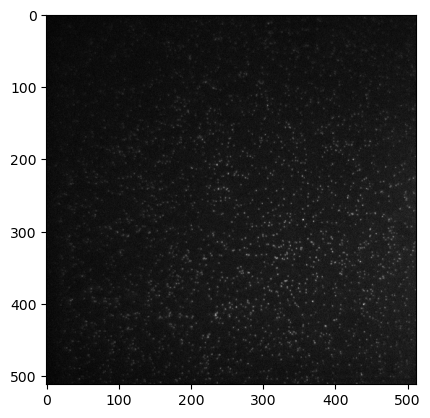

In [59]:
np.shape(red_movie)
red_movie[0,256,256]
plt.imshow(red_movie[10], cmap = 'gray')
#Image.fromarray(red_movie[0]).show()

**Background elimination :**
There are different types of background estimation : 2D-Convolution, Averaging, Gaussian Blurring, RollingBall.

The more efficient was the gaussian blurring with a high kernel size.
Here we can see examples with different techniques and different kernel size.

In [50]:
img_init = red_movie[10]
filter_size = 101
kernel = np.ones((filter_size,filter_size),np.float32)/(filter_size**2)

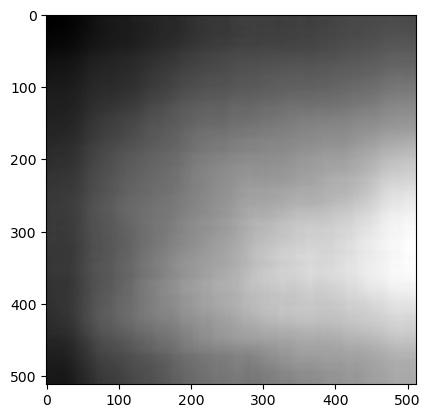

In [52]:
#2D-Convolution
dst = cv.filter2D(img_init, -1,kernel)
plt.imshow(dst, cmap= 'gray')
plt.show()

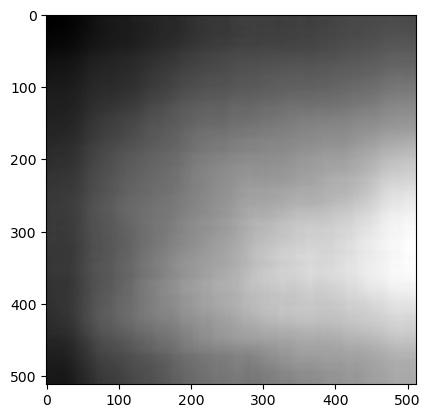

In [53]:
#Averaging convolution
blur = cv.blur(img_init,(filter_size, filter_size))
plt.imshow(blur, cmap = 'gray')
plt.show()

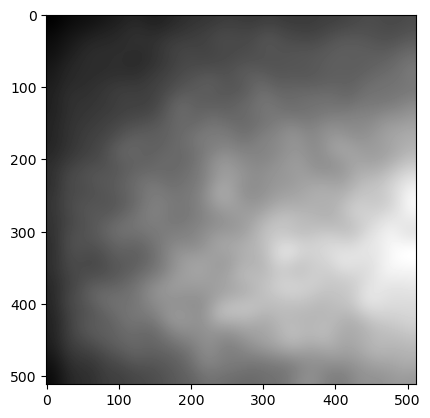

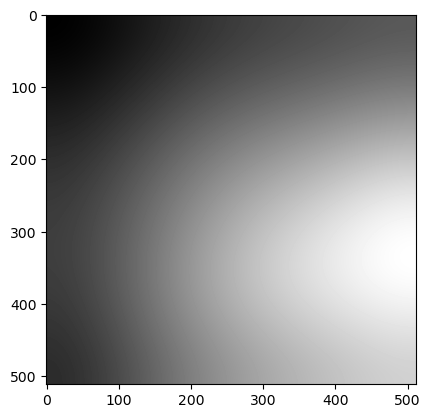

In [54]:
#Gaussian blurring with a type given kernel
blur = cv.GaussianBlur(img_init,(filter_size, filter_size),0)
plt.imshow(blur, cmap = 'gray')
plt.show()

#Gaussian blurring on the whole image
x_size_img = np.shape(img_init)[0]
if x_size_img % 2 == 0:
    x_size_img -= 1
blur = cv.GaussianBlur(img_init,(x_size_img,x_size_img),0)
plt.imshow(blur, cmap = 'gray')
plt.show()

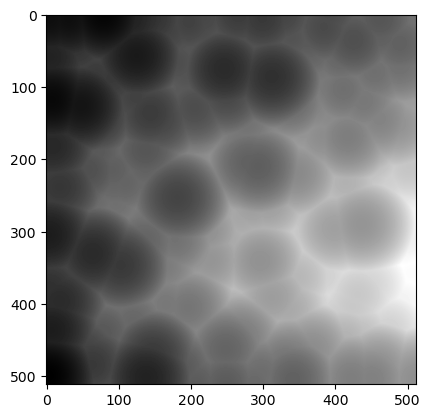

In [56]:
#Rollingball
#Donne des résultats étranges mais forme de jolies images
background = restoration.rolling_ball(img_init, radius=filter_size)
plt.imshow(background, cmap = 'gray')
plt.show()

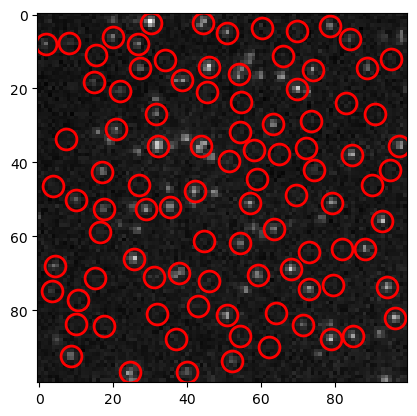

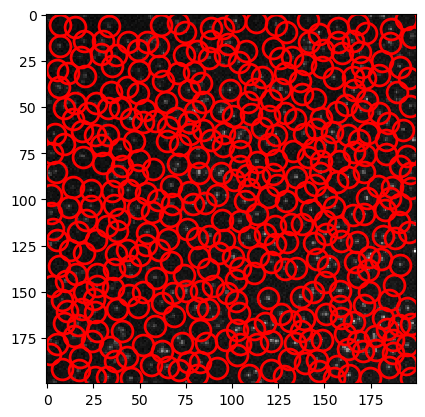

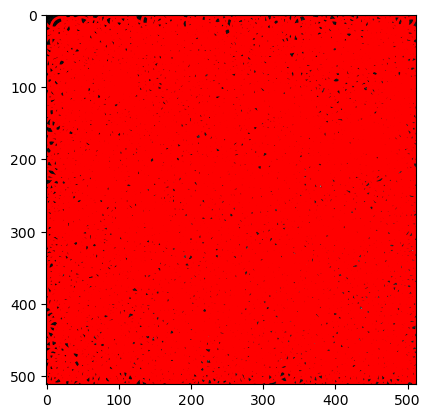

<AxesSubplot:>

In [73]:
size = 5
minmass = 0.21

frame = red_movie[10][206:306,206:306]
frame_2 = red_movie[10][156:356,156:356]
f = tp.locate(frame, size, minmass)
tp.annotate(f, frame)
f_2 = tp.locate(frame_2, size, minmass)
tp.annotate(f_2, frame_2)
f_3 = tp.locate(red_movie[10], size, minmass)
tp.annotate(f_3, red_movie[10])

In [77]:
tp.quiet() 
t = tp.link(peak_position, 5, memory=5)
print(t)
print(t['particle'].max())

t_1 = tp.filter_stubs(t, 10) #which keeps only trajectories that last for a given number of frames
print(t_1)
print(t_1['particle'].max())

print(len(t_1)/len(t))

                 y           x         mass      size       ecc      signal  \
0         2.019656   79.014742  2491.478431  1.455313  0.107116  250.984314   
1671    340.047710  287.996183  3207.701961  1.428312  0.107862  330.564706   
1672    340.010823  443.025974  2828.164706  1.467542  0.124105  263.227451   
1673    339.919065  495.929856  3403.592157  1.418024  0.092709  373.415686   
1674    340.913842  204.933616  4334.070588  1.364398  0.090820  557.062745   
...            ...         ...          ...       ...       ...         ...   
249680  179.012483  181.022191  4207.247059  1.340193  0.146420  571.858824   
249681  179.022088  288.012048  2905.976471  1.476047  0.116141  262.588235   
249682  179.968109   59.000000  2561.694118  1.453924  0.124786  268.423529   
249675  178.016484  479.983516  3186.070588  1.458837  0.108558  332.611765   
251370  509.028866  415.002062  2830.117647  1.450915  0.071599  256.752941   

        raw_mass  ep  frame  particle  
0         2

This filtering cause an important number of void in the particle index list (there is a particle 100, a particle 110, but no one between them). This means than ```t_1['particle'].max()``` does not correspond to the number of particles in the filter dataframe.

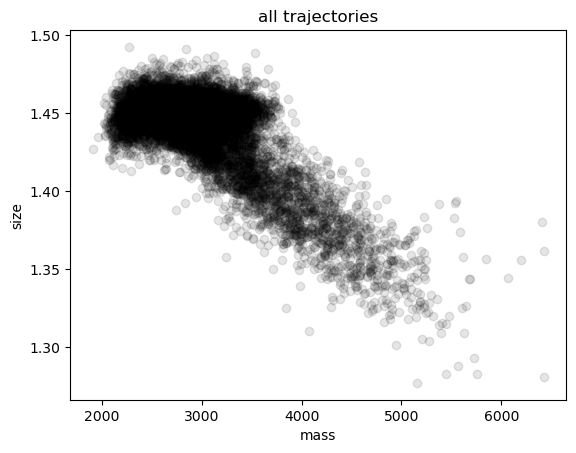

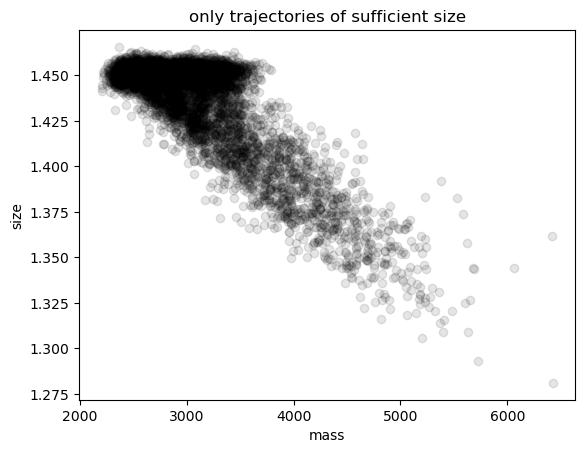

<AxesSubplot:title={'center':'only trajectories of sufficient size'}, xlabel='mass', ylabel='size'>

In [81]:
plt.figure()
plt.title('all trajectories')
tp.mass_size(t.groupby('particle').mean())

plt.figure()
plt.title('only trajectories of sufficient size')
tp.mass_size(t_1.groupby('particle').mean())

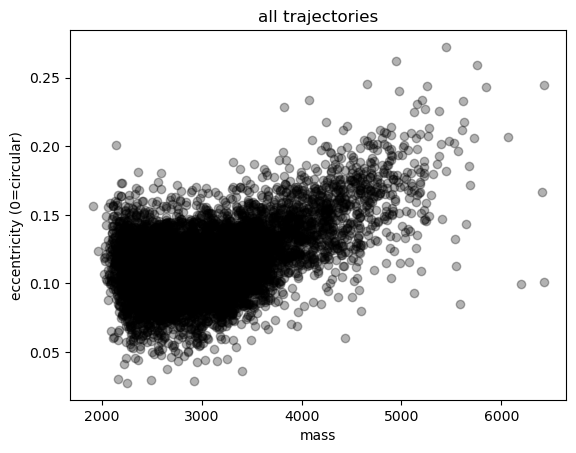

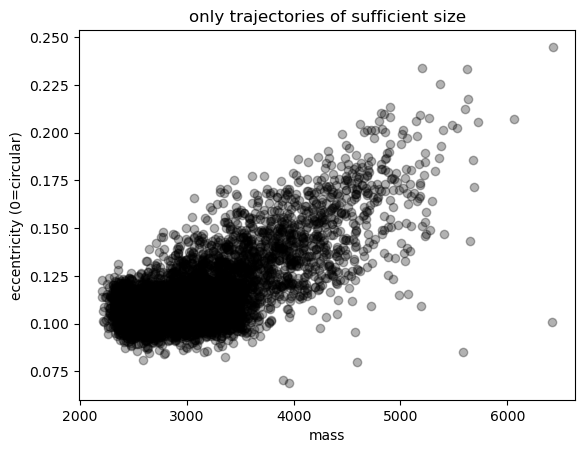

<AxesSubplot:title={'center':'only trajectories of sufficient size'}, xlabel='mass', ylabel='eccentricity (0=circular)'>

In [80]:
plt.figure()
plt.title('all trajectories')
tp.mass_ecc(t.groupby('particle').mean())

plt.figure()
plt.title('only trajectories of sufficient size')
tp.mass_ecc(t_1.groupby('particle').mean())

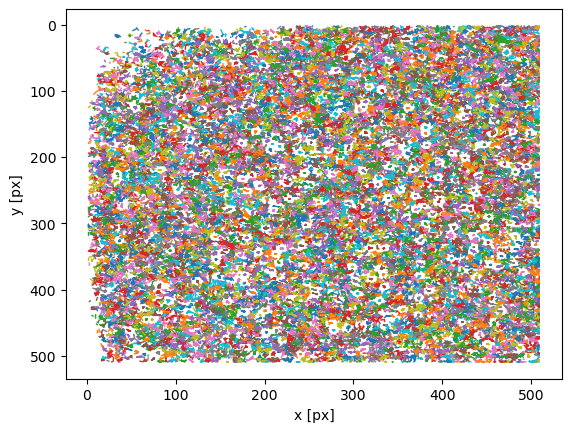

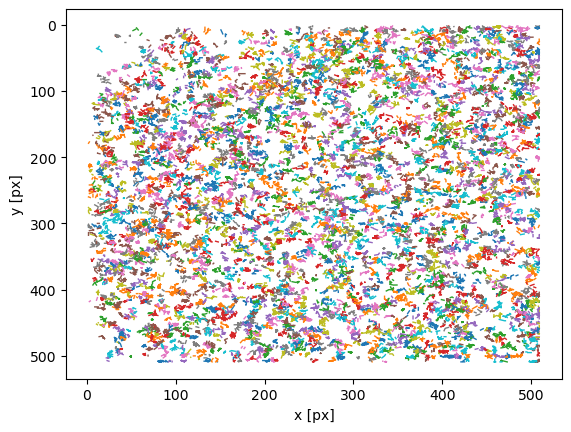

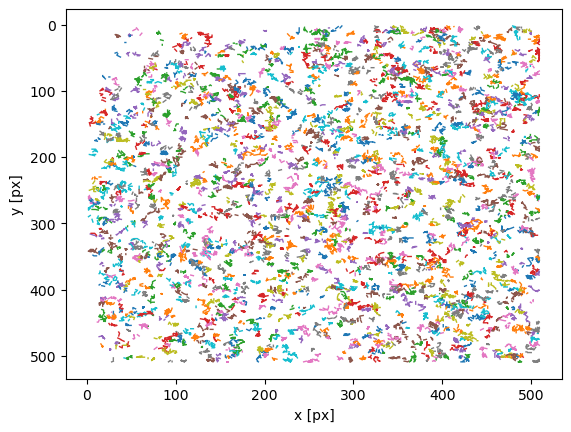

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [82]:
plt.figure()
tp.plot_traj(t_1)

t_1_reduced_3 = t_1[t_1['particle']%3 == 0]
plt.figure()
tp.plot_traj(t_1_reduced_3)

t_1_reduced_5 = t_1[t_1['particle']%5 == 0]
plt.figure()
tp.plot_traj(t_1_reduced_5)

**Parameters to optimize :**
- the **diameter, minmass and percentile** of the **```tp.batch```** function;
- the **memory time** (the maximum time during which a particle can disappear) of the **```tp.link```** function;
- The **threshold** (minimum number of points (video frames) to keep the trajectory) of the **```filter_stubs```** function;